In [1]:
TRAIN = '/kaggle/input/indian-bird-species-dataset-traintest-split/Birds25_Split/train'
TEST = '/kaggle/input/indian-bird-species-dataset-traintest-split/Birds25_Split/test'

We want to use image embeddings for both EDA and classification, so let's add some code to get those using ResNeXt without fine-tuning.

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 145MB/s]


Let's load up a sample of our data, including image embeddings and thumbnails. The more data we load the longer it will take, and it will always seem like a long time because we have 25 classes.

In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from os.path import isdir
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'] )
        for index, input_file in enumerate(list(iglob(pathname=arg))) if index < 20]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*') if isdir(folder)}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
test_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TEST + '/*') if isdir(folder)}
test_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in test_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 20 rows of Common_Tailorbird  in 0:00:04.300540
encoded 20 rows of Ruddy_Shelduck  in 0:00:03.839644
encoded 20 rows of Asian_Green_Bee_eater  in 0:00:03.870813
encoded 20 rows of Sarus_Crane  in 0:00:04.004923
encoded 20 rows of Indian_Roller  in 0:00:03.802758
encoded 20 rows of Red_Wattled_Lapwing  in 0:00:03.948870
encoded 20 rows of Indian_Grey_Hornbill  in 0:00:04.053756
encoded 20 rows of Forest_Wagtail  in 0:00:04.071569
encoded 20 rows of White_Breasted_Kingfisher  in 0:00:03.909307
encoded 20 rows of House_Crow  in 0:00:03.975800
encoded 20 rows of Northern_Lapwing  in 0:00:03.931008
encoded 20 rows of White_Breasted_Waterhen  in 0:00:04.091319
encoded 20 rows of Gray_Wagtail  in 0:00:03.845227
encoded 20 rows of Cattle_Egret  in 0:00:03.931403
encoded 20 rows of Common_Myna  in 0:00:04.061559
encoded 20 rows of Rufous_Treepie  in 0:00:03.936225
encoded 20 rows of Hoopoe  in 0:00:03.834548
encoded 20 rows of Coppersmith_Barbet  in 0:00:03.828446
encoded 20 rows of Jun

When we load up a small sample, our classes will always be balanced, but if we load up large samples or the whole dataset they may become unbalanced. When we have 25 classes and long class names there's no compact representation of class balance, so we'll just make a big long table.

In [4]:
train_df['tag'].value_counts(normalize=True).to_frame()

proportion
tag                                  
Common_Tailorbird                0.04
Cattle_Egret                     0.04
Brown_Headed_Barbet              0.04
Common_Kingfisher                0.04
Indian_Peacock                   0.04
Common_Rosefinch                 0.04
Indian_Pitta                     0.04
Jungle_Babbler                   0.04
Coppersmith_Barbet               0.04
Hoopoe                           0.04
Rufous_Treepie                   0.04
Common_Myna                      0.04
Gray_Wagtail                     0.04
Ruddy_Shelduck                   0.04
White_Breasted_Waterhen          0.04
Northern_Lapwing                 0.04
House_Crow                       0.04
White_Breasted_Kingfisher        0.04
Forest_Wagtail                   0.04
Indian_Grey_Hornbill             0.04
Red_Wattled_Lapwing              0.04
Indian_Roller                    0.04
Sarus_Crane                      0.04
Asian_Green_Bee_eater            0.04
White_Wagtail                    0.04

Next let's use TSNE to add x/y coordinates based on our image embeddings. We are going to use these to make a big scatter plot and look for clusters. The more compact and distinct our clusters are, provided the clusters align with our classes, the better accuracy we can expect from our model.

In [5]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))
test_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
test_df[['x', 'y']] = test_reducer.fit_transform(X=test_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.003s...
[t-SNE] Computed neighbors for 500 samples in 0.118s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 3.823547
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.406097
[t-SNE] KL divergence after 1000 iterations: 1.195007
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.003s...
[t-SNE] Computed neighbors for 500 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 3.846198
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.636383
[t-SNE] KL divergence after 1000 iterations: 1.166123


Let's plot.

In [6]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']].sample(n=min(len(train_df) - 1, 10000)))
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: birds!', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? A few clusters, but mostly mixing. We should have moderate expectations of our model accuracy. Let's build a model and see what we get.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

logreg = LogisticRegression(max_iter=10000, tol=1e-12).fit(train_df['value'].apply(func=pd.Series), train_df['tag'])
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series)))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series)))))
print(classification_report(zero_division=0.0, y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series))))

model fit in 164 iterations
accuracy: 0.6660
f1: 0.6639
                           precision    recall  f1-score   support

    Asian_Green_Bee_eater       0.57      0.85      0.68        20
      Brown_Headed_Barbet       0.76      0.65      0.70        20
             Cattle_Egret       0.94      0.80      0.86        20
        Common_Kingfisher       0.60      0.75      0.67        20
              Common_Myna       0.67      0.50      0.57        20
         Common_Rosefinch       0.68      0.85      0.76        20
        Common_Tailorbird       0.71      0.60      0.65        20
       Coppersmith_Barbet       0.48      0.75      0.59        20
           Forest_Wagtail       0.74      0.70      0.72        20
             Gray_Wagtail       0.74      0.85      0.79        20
                   Hoopoe       0.65      0.55      0.59        20
               House_Crow       0.54      0.65      0.59        20
     Indian_Grey_Hornbill       0.50      0.50      0.50        20
     

None of our precisions are bad, actually, but a lot of them are not very good. And they run the gamut. Our recalls aren't as good, generally. This is just a tough problem, with lots of classes and (so far) not a lot of instances per class. Let's look at our model probabilities.

<Axes: xlabel='probability', ylabel='Count'>

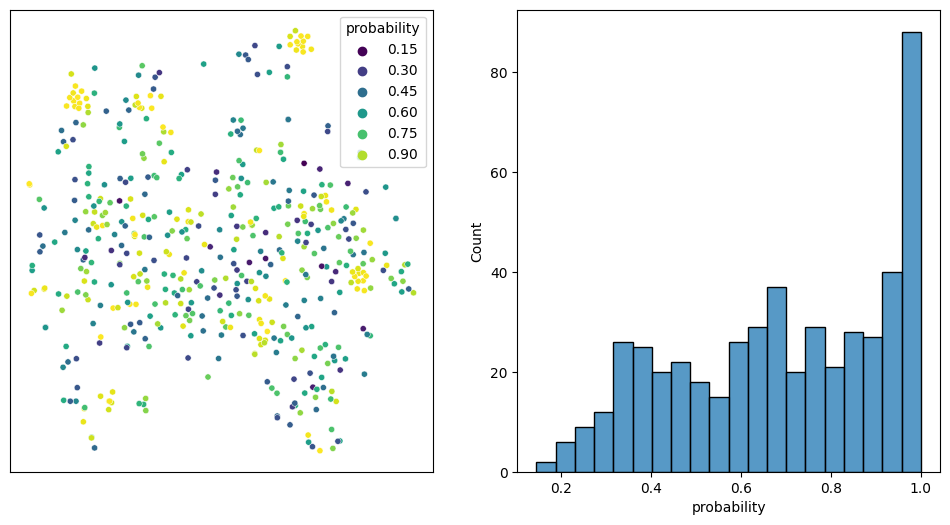

In [8]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = test_df[['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=test_df['value'].apply(func=pd.Series)), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis', s=20)
ax[0].set(xlabel=None)
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

Our model probabilites say we have three to five good class clusters and a lot of low to middling probabilities and a lot of mixing. 